In [1]:
import os
os.chdir("./..")
os.getcwd()

'/home/carlos/Documentos/proyectos/breast_cancer'

In [2]:
import yaml
import torch
import random 
import matplotlib.pyplot as plt

In [164]:
from src.utils.models import load_pretrained_model
from src.utils.models import init_segmentation_model, init_loss_function
from src.utils.visualization import plot_overlapping
from src.dataset.BUSI_dataloader import BUSI_dataloader

In [4]:
def plot_filter_correlations(filters):
    n_filters, n_channels, height, width = filters.shape
    corr_matrix = np.zeros((n_filters, n_filters))
    
    for i in range(n_filters):
        for j in range(n_filters):
            corr = np.corrcoef(filters[i].ravel(), filters[j].ravel())[0, 1]
            corr_matrix[i, j] = np.abs(corr)
            
    fig, ax = plt.subplots(figsize=(21, 21))
    im = ax.imshow(corr_matrix, cmap='Reds')
    ax.set_xticks(np.arange(n_filters))
    ax.set_yticks(np.arange(n_filters))
    ax.set_xticklabels(np.arange(n_filters))
    ax.set_yticklabels(np.arange(n_filters))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    for i in range(n_filters):
        for j in range(n_filters):
            text = ax.text(j, i, round(corr_matrix[i, j],2),
                           ha="center", va="center", color="w")
    ax.set_title("Filter Correlations")
    fig.colorbar(im)
    plt.show()
    
    
def plot_correlations(filters):
    
    fig = plt.Figure(figsize=(8, 8))
    # calculate the correlation matrix using numpy.corrcoef()
    corr_matrix = np.corrcoef(filters.reshape(filters.shape[0], -1))

    # plot the correlation matrix using matplotlib
    plt.imshow(np.abs(corr_matrix), cmap='coolwarm')
    plt.colorbar()
    plt.title('Pairwise Correlation of Filters', fontsize=16)
    plt.show()

In [5]:
def dice_score_from_numpy(gt, seg) -> float:
    gt = gt.astype(float)
    seg = seg.astype(float)
    
    tp = np.sum(np.logical_and(seg, gt)).astype(float)
    tn = np.sum(np.logical_and(np.logical_not(seg), gt)).astype(float)
    fp = np.sum(np.logical_and(seg, np.logical_not(gt))).astype(float)
    fn = np.sum(np.logical_and(np.logical_not(seg), gt)).astype(float)

    if np.sum(gt) == 0:
        dice = 1 if np.sum(seg) == 0 else 0
    else:
        dice = 2 * tp / (2 * tp + fp + fn)

    return dice

In [ ]:

def get_random_element(dataloader):
    random_idx = random.randint(0, len(dataloader)-1)
    for i, data in enumerate(dataloader):
        if i == random_idx:
            return data

# Binary segmentation

In [8]:
experiment_path = './runs/20230927_191939_FSB_BTS_UNet_24_batch_1_benign_malignant_results'

if torch.cuda.is_available():
    dev = "cuda:0"
    print("GPU will be used to train the model")
else:
    dev = "cpu"
    print("CPU will be used to train the model")

GPU will be used to train the model


In [162]:
with open(f'{experiment_path}/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config_model = config['model']
config_training = config['training']
config_data = config['data']
config_loss = config['loss']

In [165]:
loss_fn = init_loss_function(loss_function=config_loss['function'])

In [10]:
model = init_segmentation_model(architecture=config_model['architecture'],
                                sequences=config_model['sequences'],
                                width=config_model['width'],
                                deep_supervision=config_model['deep_supervision'],
                                save_folder=None).to(dev)

model = load_pretrained_model(model, f'{experiment_path}/fold_0/model_20230927_191939_fold_0')

2023-10-07 12:18:42,913 - Creating FSB_BTS_UNet model
2023-10-07 12:18:42,914 - The model will be fed with 1 sequences
2023-10-07 12:18:42,928 - FSB_BTS_UNet(
  (encoder1): LevelBlock(
    (ConvInNormLRelu1): ConvInNormLeReLU(
      (Conv): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (LeReLU): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (ConvInNormLRelu2): ConvInNormLeReLU(
      (Conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (LeReLU): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder2): LevelBlock(
    (ConvInNormLRelu1): ConvInNormLeReLU(
      (Conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(24, eps=1e-05, mo

2023-10-07 12:18:42,929 - Total number of trainable parameters: 2009960
2023-10-07 12:18:43,465 - Loaded checkpoint './runs/20230927_191939_FSB_BTS_UNet_24_batch_1_benign_malignant_results/fold_0/model_20230927_191939_fold_0'. Last epoch: 296


In [11]:
training_loader, validation_loader, test_loader = BUSI_dataloader(seed=config_training['seed'],
                                                                  batch_size=config_data['batch_size'],
                                                                  transforms=None,
                                                                  train_size=config_data['train_size'],
                                                                  augmentations=config_data['augmentation'],
                                                                  normalization=None,
                                                                  classes=config_data['classes'],
                                                                  path_images=config_data['input_img'])


2023-10-07 12:18:48,314 - Images are contained in the following path: /home/carlos/Documentos/proyectos/breast_cancer/Datasets/Dataset_BUSI_with_GT_postprocessed_128_uniques
2023-10-07 12:18:48,321 -      Unnamed: 0                                           img_path                                          mask_path      class   id  ...  y_min  x_max  x_min  y_size  x_size
114         114  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...     benign  184  ...     22    126     27      28      99
282         282  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   84  ...     41    109     50      49      59
99           99  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...     benign  168  ...     42     80     41      26      39
180         180  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with

2023-10-07 12:18:48,325 -      Unnamed: 0                                           img_path                                          mask_path      class   id  ...  y_min  x_max  x_min  y_size  x_size
351         351  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant  176  ...      9     67     11      54      56
239         239  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   30  ...      7     93     18      98      75
288         288  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   91  ...     13    104     34      62      70
261         261  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   57  ...      9    125     58      47      67
155         155  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_wi

In [122]:
sample = get_random_element(test_loader)
img = sample['image'].to(dev)
mask = sample['mask'].numpy()[0, 0, :, :]
print(img.shape)
print(mask.shape)

torch.Size([1, 1, 128, 128])
(128, 128)


In [123]:
# sample

In [124]:
seg = model(img)
print(type(seg))
print(len(seg))
print(seg[-1].shape)

img = img.detach().cpu().numpy()[0, 0, :, :]
feat_maps = [torch.sigmoid(ds).detach().cpu().numpy()[0, 0, :, :] for ds in seg]

<class 'list'>
8
torch.Size([1, 1, 128, 128])


In [125]:
def plot_images(images, titles):
    num_images = len(images)
    rows = 2
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    for i in range(rows):
        for j in range(cols):
            if i*cols + j < num_images:
                axes[i, j].imshow(images[i*cols + j])
                axes[i, j].axis('off')
                axes[i, j].set_title(titles[i*cols + j])
                
    plt.tight_layout()
    plt.show()

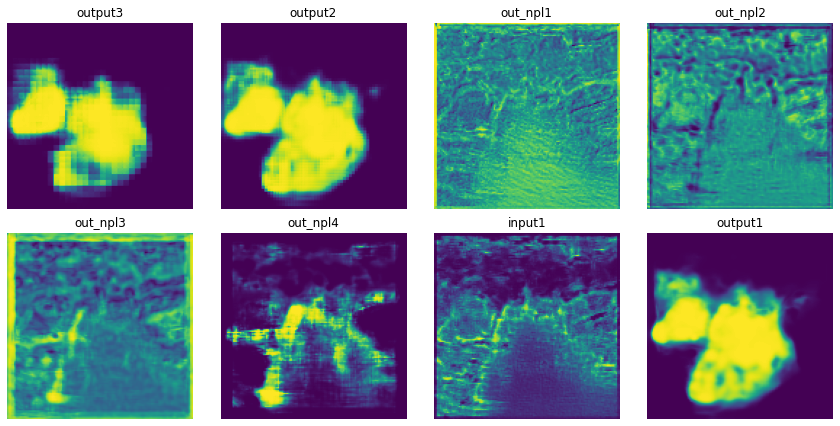

In [126]:
plot_images(feat_maps, 
            titles=['output3', 'output2', 'out_npl1', 'out_npl2', 'out_npl3', 'out_npl4', 'input1', 'output1'])

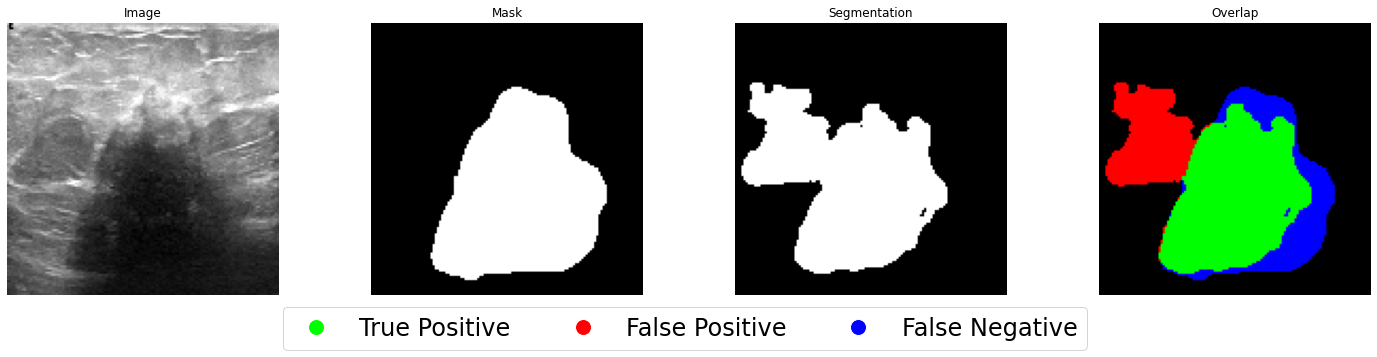

In [133]:
plot_overlapping(img, mask, feat_maps[-1] > .5)

In [134]:
dices = [dice_score_from_numpy(mask, f > .5) for f in feat_maps]
dices

[0.6474523932063819,
 0.7299077733860343,
 0.5179440551960207,
 0.13768472906403942,
 0.27144526684846126,
 0.4599236641221374,
 0.18775995246583482,
 0.724247993036077]

# Saliency map

In [250]:
# Define the saliency map function
def get_saliency_map(model, input_image, target_class):
    # Set the model to evaluation mode
    model.eval()

    # Get the outputs at different layers of the network
    output3, output2, out_npl1, out_npl2, out_npl3, out_npl4, input1, output1 = model(input_image)

    # Compute the gradients for each output
#     grad1 = torch.autograd.grad(torch.sigmoid(input1)[:, target_class].sum(), input_image, create_graph=True)[0]
    grad1 = torch.autograd.grad(output3[:, target_class].sum(), input_image, create_graph=True)[0]
#     grad2 = torch.autograd.grad(output2[:, target_class].sum(), input_image, create_graph=True)[0]
#     grad3 = torch.autograd.grad(output3[:, target_class].sum(), input_image, create_graph=True)[0]

    # Compute the saliency maps for each output
    saliency1 = torch.abs(grad1).max(dim=1)[0]
#     saliency2 = torch.abs(grad2).max(dim=1)[0]
#     saliency3 = torch.abs(grad3).max(dim=1)[0]

    # Combine the saliency maps by taking the maximum pixel value across all maps at each location
    saliency_map = torch.max(torch.stack([saliency1]), dim=0)[0][0]
#     saliency_map = torch.max(torch.stack([saliency1, saliency2, saliency3]), dim=0)[0]

    # Normalize the saliency map
    saliency_map = saliency_map / saliency_map.max()

    # Convert the saliency map to a numpy array and return it
    return saliency_map.detach().cpu().numpy()

In [251]:
def generate_saliency_maps_segmentation(model, input_image, output_image):
    # Set the model to evaluation mode
    model.eval()

    # Enable gradients for the input image
    input_image.requires_grad = True
    output_image.requires_grad = True

    saliency_maps = []

    output3, output2, out_npl1, out_npl2, out_npl3, out_npl4, input1, output1 = model(input_image)

    # Calculate gradients
    loss = torch.sum(loss_fn(output3, output_image))
    loss.backward()

    # Get the gradients
    saliency_map = input_image.grad.data.abs().squeeze()
#         saliency_map = input_image.grad.data.abs().squeeze().sum(dim=0)

    # Reset gradients for next iteration
    model.zero_grad()

    return saliency_map.detach().cpu().numpy()


In [252]:
def plot_saliency_map(input_image: torch.Tensor, mask: np.array, saliency_map:np.array):
    # Plot the input image and the saliency map
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(np.transpose(input_image[0].detach().cpu().numpy(), (1, 2, 0)), cmap='gray')
    axs[0].set_title('Input')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')
    axs[2].imshow(saliency_map[:, :], cmap=plt.cm.hot)
    axs[2].set_title('Saliency map')
    axs[2].axis('off')
    plt.show()

In [232]:
# Define the input image and label
sample = get_random_element(test_loader)
input_image = sample['image'].to(dev)
output_image = sample['mask'].to(dev)
input_image.requires_grad_()
output_image.requires_grad_()

mask = sample['mask'].numpy()[0, 0, :, :]

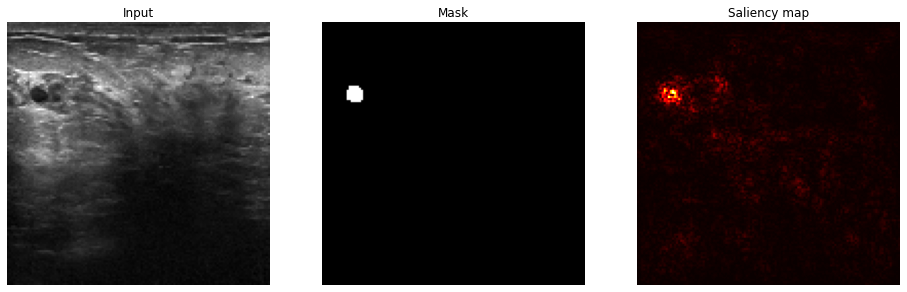

In [253]:
saliency_map = get_saliency_map(model, input_image, target_class=0)
plot_saliency_map(input_image, mask, saliency_map)

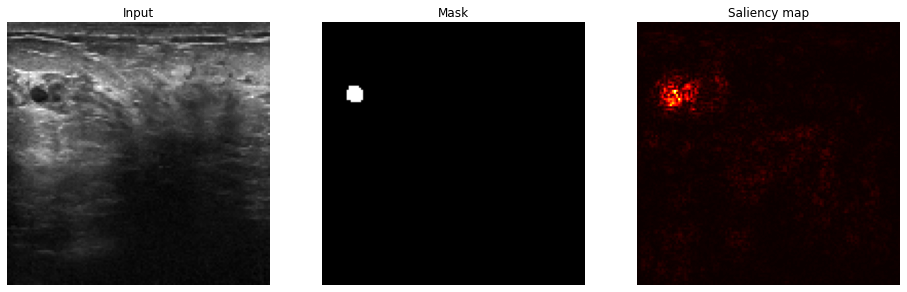

In [254]:
saliency_map = generate_saliency_maps_segmentation(model, input_image, output_image)
plot_saliency_map(input_image, mask, saliency_map)